In [71]:
import numpy as np
import pandas as pd

#Feature Description
#CensusTract, SchoolYear, GradeLevel, Count given from DOE. SchoolYear 0 means Grade K

###Added features###
#TotalCount = Total number of students for a given year across all tract and grade
#TotalCountByGrade = Total number of students for a given year and grade across all tract
#TotalCountByTract = Total number of students for a given year and tract across all grade
#TotalCountByZip = Total number of studetns for a given year and zip across all grade
#TotalCountByZipGrade = Total number of students for a given year, zip and grade
#TotalCountByTractGrade = Same as Count // can be removed
#PrevGradeCount = Total number of students from prior grade for a given yaer and tract
#e.g, for year 2010, tract 18, grade 5, its PrevGradeCount will be Count from year 2010, tract 18 and grade 4
#PrevGradeCountmavg3 = 3 year average of PrevGradeCount
#PrevGradeCountmavg5 = 5 year average of PreveGradeCount
#OneYearGrowth = one year growth rate of Count for a given tract and grade
#ThreeYearGrowth = three year growth rate of Count for a given tract and grade
#OneYearGrowthmavg3 = 3 year average of OneYearGrowth
#ThreeYearGrowthmavg3 = 3 year average of ThreeYearGrowth
#Y = Target variable 1 = Increase in count in the next year, 0 = decrease/stay the same in the next year

##We can ignore Target,Y2 columns in newt.csv // I will clean up later
df = pd.read_csv('newt.csv')
df = df[df.SchoolYear<2010]
df = df.drop(['Target','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns
test_df = df[df.SchoolYear>2007] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2007] # Training set from 2001 to 2007
df.head()

,CensusTract,SchoolYear,GradeLevel,Count,TotalCount,TotalCountByGrade,TotalCountByTract,TotalCountByZip,TotalCountByZipGrade,PrevGradeCount,PrevGradeCountmavg3,PrevGradeCountmavg5,OneYearGrowth,ThreeYearGrowth,OneYearGrowthmavg3,ThreeYearGrowthmavg3,Y
0,18,2001,0,0,16366,2705,1,3394,563,0,0,0,0.0,0.0,0.000000,0.0,0
1,18,2002,0,0,16351,2614,1,3340,526,0,0,0,0.0,0.0,0.000000,0.0,1
2,18,2003,0,1,16278,2547,3,3286,519,0,0,0,0.0,0.0,0.000000,0.0,0
3,18,2004,0,0,16088,2606,2,3197,535,0,0,0,-1.0,0.0,-0.333333,0.0,0
4,18,2005,0,0,15897,2615,2,3152,537,0,0,0,0.0,0.0,-0.333333,0.0,0


In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y

clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(train_df_x, train_df_y)

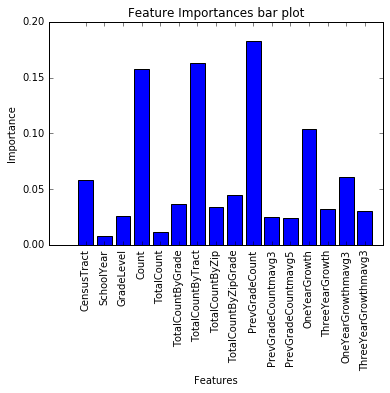

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

feature_importances = clf.feature_importances_

plt.figure()
plt.title('Feature Importances bar plot')
plt.bar(range(train_df_x.shape[1]), feature_importances, align='center')
plt.xticks(range(train_df_x.shape[1]), train_df_x.columns, rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Importance")

In [74]:
from scipy.stats import pearsonr
order = np.argsort(feature_importances)[::-1]
print("Top 5 most important features")
for n,i in enumerate(order[:5]):
    print("%d"%(n+1),train_df_x.columns[i],feature_importances[i])

Top 5 most important features
1 PrevGradeCount 0.182973115363
2 TotalCountByTract 0.162844952755
3 Count 0.157543978676
4 OneYearGrowth 0.103715175776
5 OneYearGrowthmavg3 0.0609121282917


In [75]:
cm = confusion_matrix(clf.predict(train_df_x), train_df_y)
print("Accuracy on train_df: ",(cm[0][0] + cm[1][1]) / float(sum(sum(cm))))
cm2 = confusion_matrix(clf.predict(test_df_x), test_df_y)
print("Accuracy on test_df: ",(cm2[0][0] + cm2[1][1]) / float(sum(sum(cm2))))


Accuracy on train_df:  1.0
Accuracy on test_df:  0.757430997877


In [76]:
min_samples_split_values = [round(int(len(train_df_x)*0.01*i),-1) for i in range(1,11,1)]#np.arange(300,3001,300)
min_samples_leaf_values = [round(int(len(train_df_x)*0.05*i*0.1),-1) for i in range(1,11,1)]
print(min_samples_split_values)
print(min_samples_leaf_values)

[60, 130, 200, 260, 330, 400, 460, 530, 590, 660]
[30, 60, 100, 130, 160, 200, 230, 260, 300, 330]


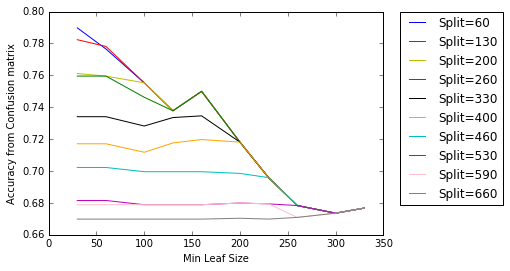

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

result = dict()

for i in min_samples_split_values:
    
    result[i] = list()
    
    for j in min_samples_leaf_values:
        
        clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = j, min_samples_split= i)
        clf = clf.fit(train_df_x, train_df_y)
        cm = confusion_matrix(clf.predict(test_df_x), test_df_y)
        result[i].append((cm[0][0] + cm[1][1]) / float(sum(sum(cm))))
        
plt.figure()
colors = ['b','r','y','g','k','orange','c','m','pink','gray','firebrick']
for n,i in enumerate(min_samples_split_values):
    plt.plot(min_samples_leaf_values, result[i], color = colors[n], label = 'Split={}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Min Leaf Size')
plt.ylabel('Accuracy from Confusion matrix')

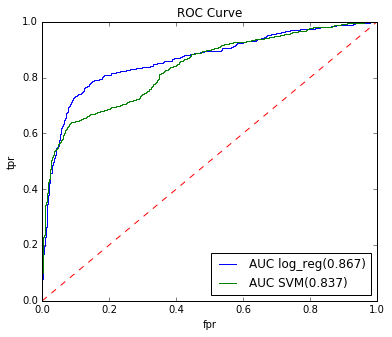

In [78]:
from sklearn import linear_model, metrics, svm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(train_df_x, train_df_y)
pred_lr = logreg.predict_proba(test_df_x)[:,1]

fpr_lr, tpr_lr, thre_lr = metrics.roc_curve(test_df_y, pred_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

my_svm = svm.SVC(kernel='linear')
my_svm.fit(train_df_x, train_df_y)
pred_svm = my_svm.decision_function(test_df_x)

fpr_svm, tpr_svm, thre_svm = metrics.roc_curve(test_df_y, pred_svm)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)

fig = plt.figure(figsize = (6, 5))
plt.title('ROC Curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--', label='')
plt.plot(fpr_lr, tpr_lr, label='AUC log_reg({0:.3f})'.format(roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, label='AUC SVM({0:.3f})'.format(roc_auc_svm))
plt.legend(loc=4)